# 1. Building Unit for Neuron Operation

In [1]:
import math

class Value:
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 # Zero means having no effect on final outputc
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    # reper allow to print nicer looking object representation
    # When you print object of class following return value of repr function get returned.
    # in this case it's string
    def __repr__(self):
        return f"Value(data={self.data})"

    # When you do add 2 object this class like (a + b), in underneath `a.__add__(b)` this kind of operation get called
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self,), f"**{other}")

        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        out._backward = _backward

        return out
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other):  # self - other
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1

        for node in reversed(topo):
            node._backward()

In [2]:
a = Value(2, label='a')
b = Value(4, label='b')
b - a

Value(data=2)

# 2. Visualization Setup

In [3]:
# !pip install graphviz
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        # dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        dot.node(name=uid, label=f"{n.label} | data:{n.data:.4f} | grad:{n.grad:.4f}", shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

# 3. Basic Example

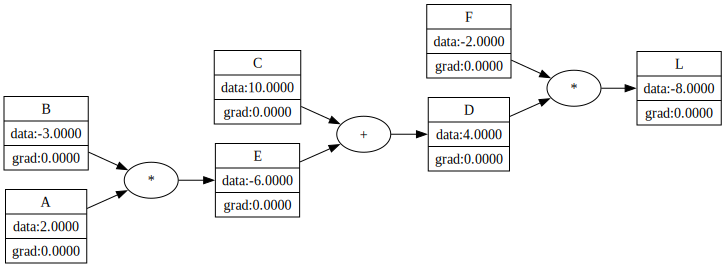

In [4]:
a = Value(2, label="A")
b = Value(-3, label="B")
c = Value(10, label="C")
e = a * b
e.label = "E"
d = e + c
d.label = "D"
f = Value(-2, label="F")
l = d * f
l.label = "L"

draw_dot(l)

# 4. Manual Back Propagation

In [5]:
# Single Neuron

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label='o'

In [6]:
# Manual Backpropagation
o.grad = o.data/o.data
o.grad

1.0

In [7]:
n.grad = 1 - o.data**2 # o = tanh(n); do/dn = 1 - o**2; derivative of tanh is 1 - [tanh(x)]**2
n.grad

0.4999999999999999

In [8]:
x1w1x2w2.grad = n.grad
b.grad = n.grad

In [9]:
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

In [10]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

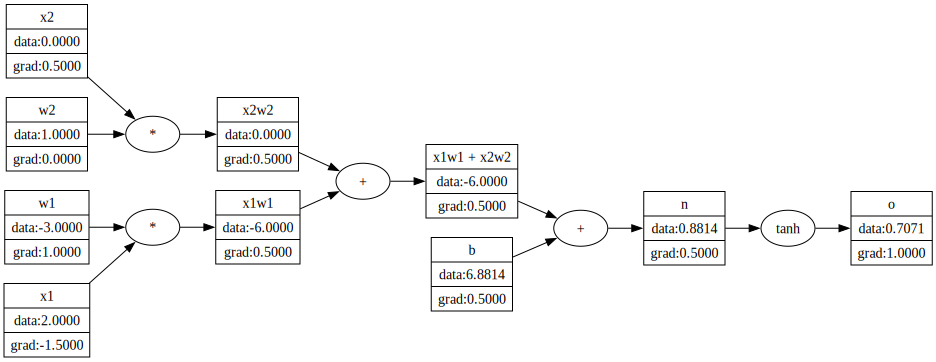

In [11]:
draw_dot(o)

# 5. Back Propagation With Manual Backward Function on each Variable

In [12]:
# Single Neuron

x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.8813735870195432, label="b")

x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1 + x2w2"

n = x1w1x2w2 + b
n.label = "n"
o = n.tanh()
o.label = "o"

In [13]:
o.grad = 1.0

In [14]:
o._backward()

In [15]:
n._backward()

In [16]:
b._backward()

In [17]:
x1w1x2w2._backward()

In [18]:
x2w2._backward()

In [19]:
x1w1._backward()

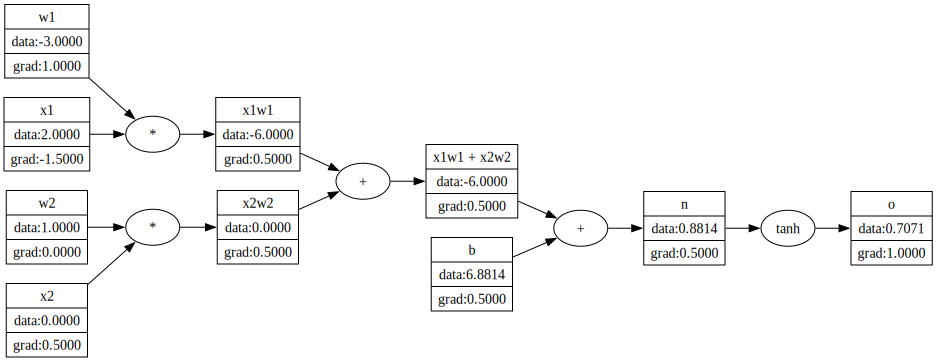

In [20]:
draw_dot(o)

# 6. Automatic Back Propagation with Topological Sort 

In [21]:
# Single Neuron

x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.8813735870195432, label="b")

x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1 + x2w2"

n = x1w1x2w2 + b
n.label = "n"
o = n.tanh()
o.label = "o"

In [22]:
topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)
o.grad = 1.0

for node in reversed(topo):
    node._backward()

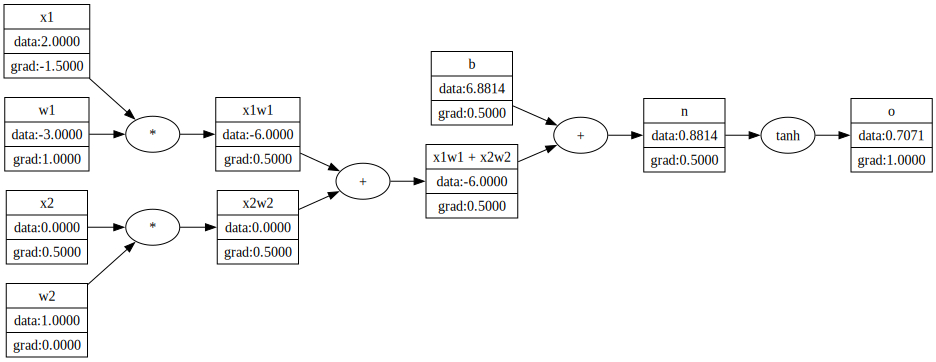

In [23]:
draw_dot(o)

# 7. Moving topological sort function inside Value class

In [24]:
# Single Neuron

x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.8813735870195432, label="b")

x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1 + x2w2"

n = x1w1x2w2 + b
n.label = "n"
o = n.tanh()
o.label = "o"

In [25]:
o.backward()

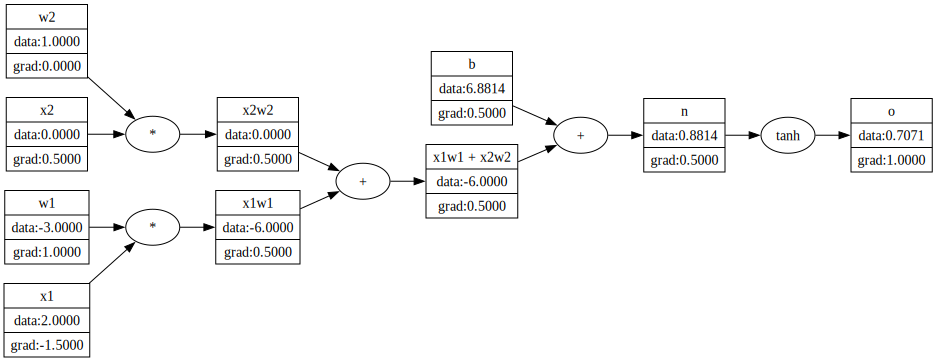

In [26]:
draw_dot(o)

# 8. Fixing a backprop bug when one node is used multiple times

Previously, Used to face issue grad of value used to get overwritten and not accumulate.

![duplicate_value_issue](./images/duplicate_value_issue.JPG)
![duplicate_value_issue_II](./images/duplicate_value_issue_II.JPG)

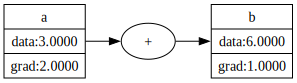

In [27]:
a = Value(3.00, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

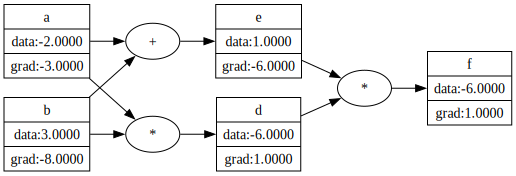

In [28]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()

draw_dot(f)

# 9. PyTorch Implementation for above thing

In [29]:
import torch

In [30]:
x1 = torch.Tensor([2.0]).double()                  ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                  ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                 ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                  ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()    ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

by default torch.Tensor is float32. attache double() to make it float64

# 10. Neural Network Building

In [31]:
import random

class Module:
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):
    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        # w*x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        return act.tanh() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):
    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

# Test the updated implementation
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
print(n)
print(f"Number of parameters: {len(n.parameters())}")
result = n(x)
print(f"Output: {result}")

MLP of [Layer of [ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3)], Layer of [ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4)], Layer of [LinearNeuron(4)]]
Number of parameters: 41
Output: Value(data=-0.5636289088201006)


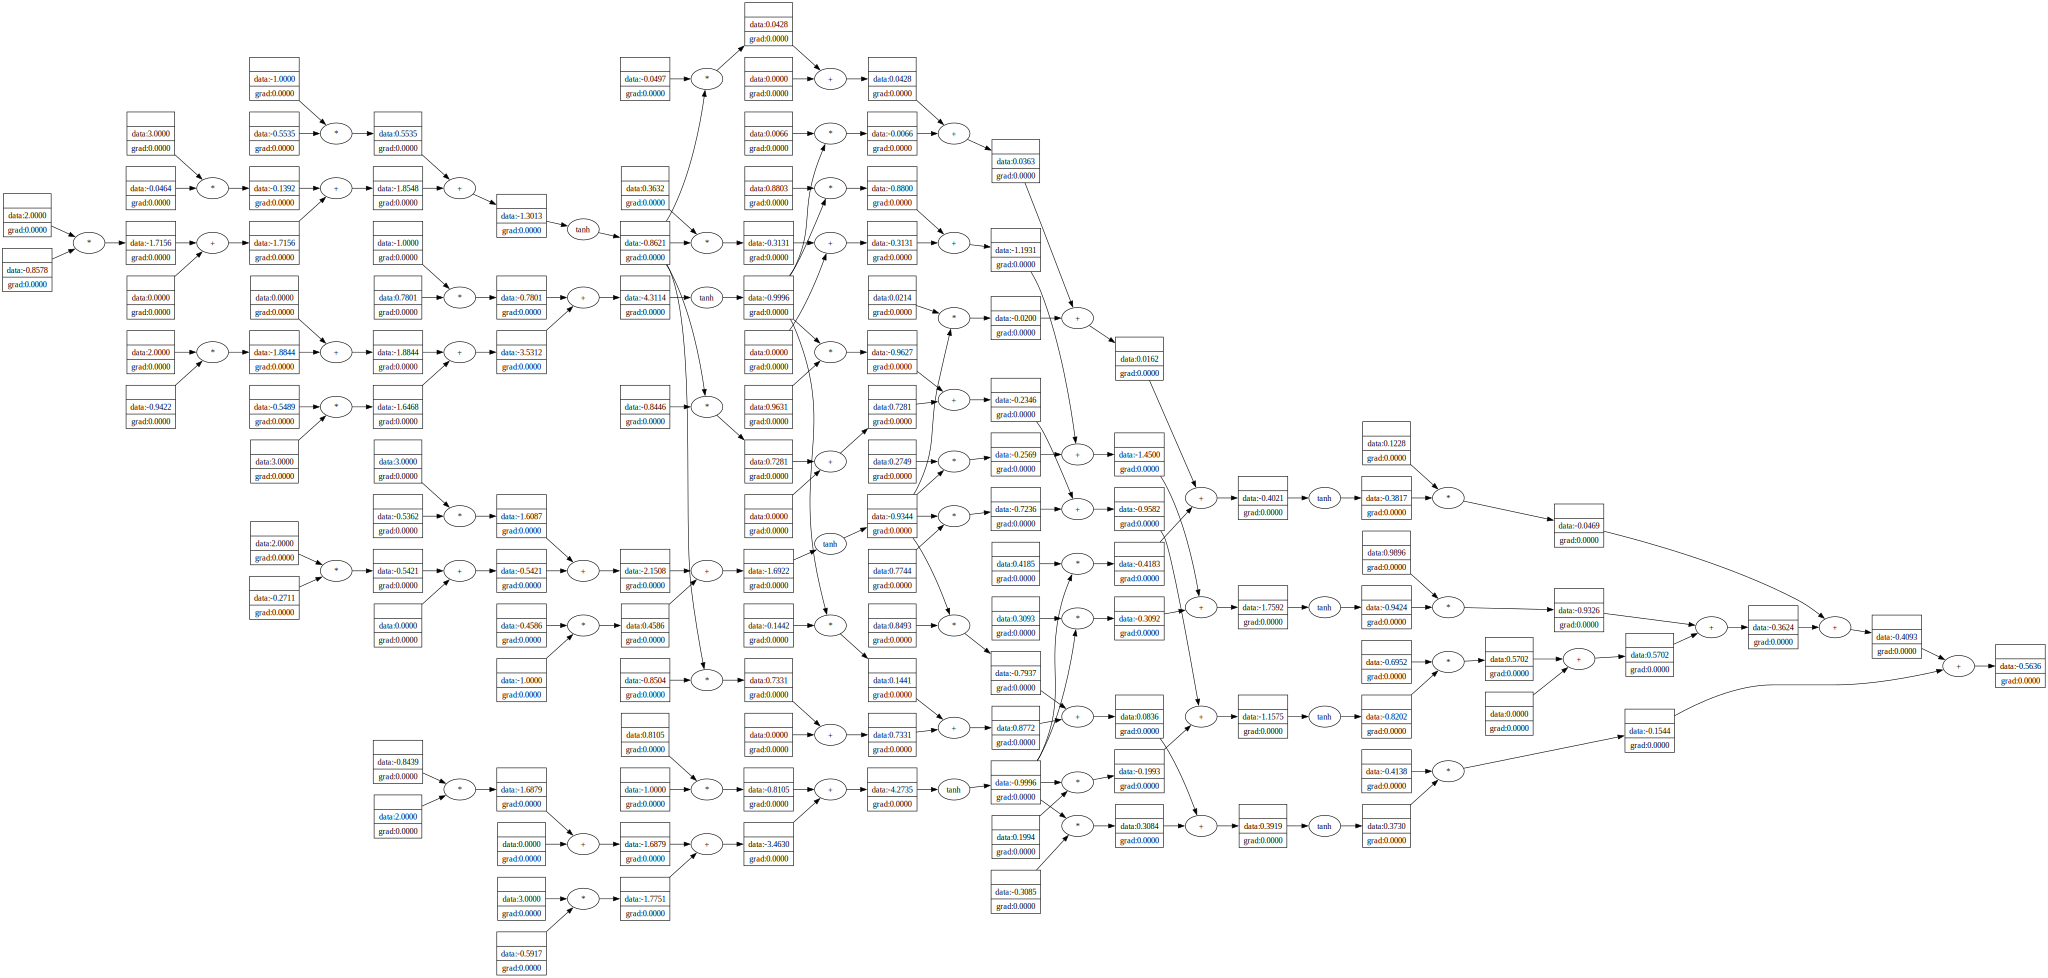

In [32]:
draw_dot(n(x))

In [33]:
# Training examples
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

# Create the MLP
n = MLP(3, [4, 4, 1])
print(f"Created MLP with {len(n.parameters())} parameters")

# Forward pass
ypred = [n(x) for x in xs]
print("Predictions:", [yp.data for yp in ypred])
print("Targets:", ys)

Created MLP with 41 parameters
Predictions: [-0.29575990335187013, 0.3071978972787207, -0.012662910730279406, 0.03327614320205663]
Targets: [1.0, -1.0, -1.0, 1.0]


In [34]:
# This will work now - providing Value(0) as start parameter for sum()
loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0))
loss

Value(data=5.297149612934251)

In [35]:
# Complete training loop 
print("Training the neural network...")
print(f"Initial loss: {loss.data:.4f}")

# Training parameters
learning_rate = 0.01
epochs = 100

for epoch in range(epochs):
    # Forward pass
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0))
    
    # Zero gradients
    n.zero_grad()
    
    # Backward pass
    loss.backward()
    
    # Update parameters
    for p in n.parameters():
        p.data -= learning_rate * p.grad
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d}: loss = {loss.data:.6f}")

print(f"\nFinal loss: {loss.data:.6f}")
print("Final predictions:", [f"{yp.data:.4f}" for yp in ypred])
print("Targets:          ", [f"{y:.4f}" for y in ys])

Training the neural network...
Initial loss: 5.2971
Epoch   0: loss = 5.297150
Epoch  10: loss = 2.014080
Epoch  20: loss = 0.092576
Epoch  30: loss = 0.006321
Epoch  40: loss = 0.003421
Epoch  50: loss = 0.002964
Epoch  60: loss = 0.002707
Epoch  70: loss = 0.002477
Epoch  80: loss = 0.002246
Epoch  90: loss = 0.002076

Final loss: 0.001949
Final predictions: ['1.0318', '-0.9991', '-0.9978', '0.9695']
Targets:           ['1.0000', '-1.0000', '-1.0000', '1.0000']
